# House Prices: Advanced Regression Techniques (Part 2)

We now move to the actual model building part. As usual, we first import some of the libraries we will be needing.

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

## Read the Cleaned Data 
First we load the data we cleaned in the previous part.

In [13]:
X_train_complete = pd.read_csv("HousePricesTrainClean.csv")
X_test = pd.read_csv("HousePricesTestClean.csv")
X_train_complete.head()

,Unnamed: 0,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0,0,1,0,0,0,0,1,0,12.247699
1,1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,0,0,1,0,0,0,0,1,0,12.109016
2,2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0,0,1,0,0,0,0,1,0,12.317171
3,3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0,0,1,1,0,0,0,0,0,11.849405
4,4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,0,0,1,0,0,0,0,1,0,12.429220


In [14]:
X_train = X_train_complete.loc[:,'MSSubClass':'SaleCondition_Partial']
y = X_train_complete['SalePrice']

## Linear Regression Models
Now we are going to use plain linear regressio and regularized models (both $L_1$ Lasso and $L_2$ Ridge) from the scikit learn module. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def r2_cv(model, X_train, y, random_state=12345678):
    r2= cross_val_score(model, X_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state))
    return(r2)

def rmse_cv(model, X_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

In [16]:
model_simple = LinearRegression()
model_simple.fit(X_train, y)
yp = model_simple.predict(X_train)

# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(y,yp)
r2_xval_simple =  r2_cv(model_simple, X_train, y)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(y,yp,multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, X_train, y)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))

Linear Regression
	                  Train R2=0.947
	10-fold Crossvalidation R2=0.720
	                  Train RMSE=0.008
	10-fold Crossvalidation RMSE=0.171


## Ridge Regression
We now try ridge regression ($L_2$) and for this purpose we need to select a value of $\alpha$. The higher the $\alpha$, the higher the penalization of weights with a large absolute value. We select a possible range of values of $\alpha$ and apply ridge for each value.

In [17]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y).mean() for alpha in alphas]
cv_r2_ridge = [r2_cv(Ridge(alpha = alpha), X_train, y).mean() for alpha in alphas]

Put the values into a table and plot them

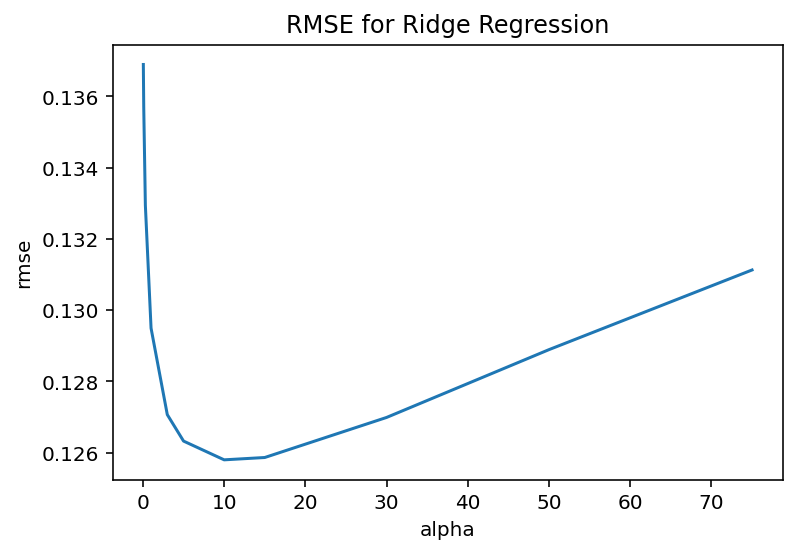

In [18]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_r2_ridge = pd.Series(cv_r2_ridge, index = alphas)

cv_ridge.plot(title = "RMSE for Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()


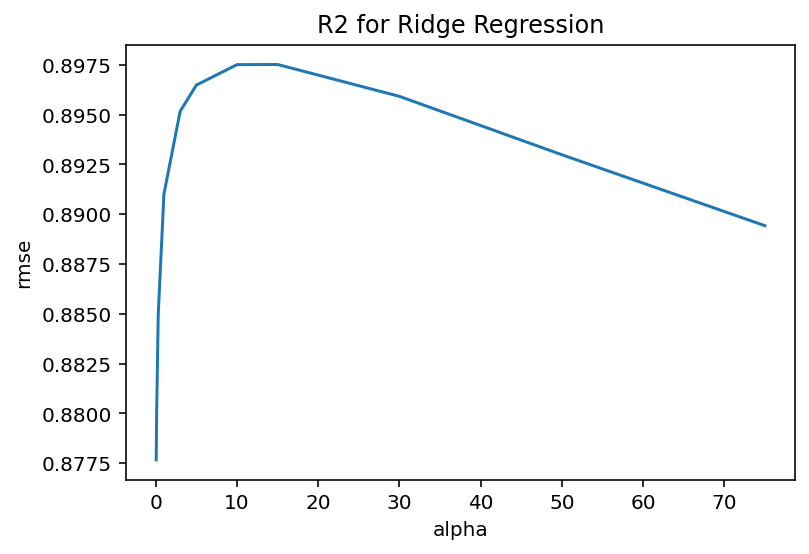

In [19]:

cv_r2_ridge.plot(title = "R2 for Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()


Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [20]:
print("Best RMSE %.3f for alpha %.3f"%(cv_ridge.min(),cv_ridge.idxmin()))
print("Best R2 %.3f for alpha %.3f"%(cv_r2_ridge.max(),cv_r2_ridge.idxmax()))
print("Why the difference? R2[10]=%.6f R2[15]=%.6f"%(cv_r2_ridge[cv_ridge.idxmin()],cv_r2_ridge[cv_r2_ridge.idxmax()]))

Best RMSE 0.126 for alpha 10.000
Best R2 0.898 for alpha 15.000
Why the difference? R2[10]=0.897505 R2[15]=0.897513


So for the Ridge regression we get a rmse of about 0.126

## Lasso Regression ($L_1$)
We now test Lasso regression. As before we need to test different values of $\alpha$. Let's try out the Lasso model. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

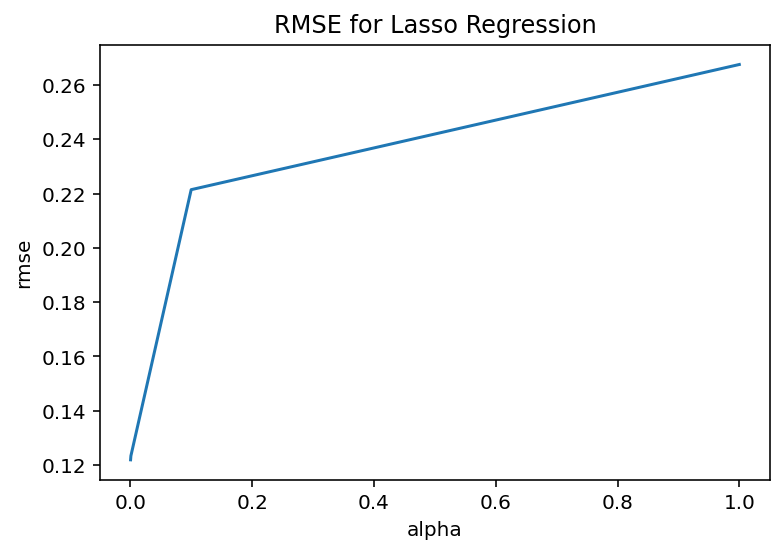

In [21]:
alphas = [1, 0.1, 0.001, 0.0005]
cv_lasso = [rmse_cv(Lasso(alpha = alpha), X_train, y).mean() for alpha in alphas]
cv_r2_lasso = [r2_cv(Lasso(alpha = alpha), X_train, y).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_r2_lasso = pd.Series(cv_r2_lasso, index = alphas)

plt.figure(figsize=(6,4))
cv_lasso.plot(title = "RMSE for Lasso Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()


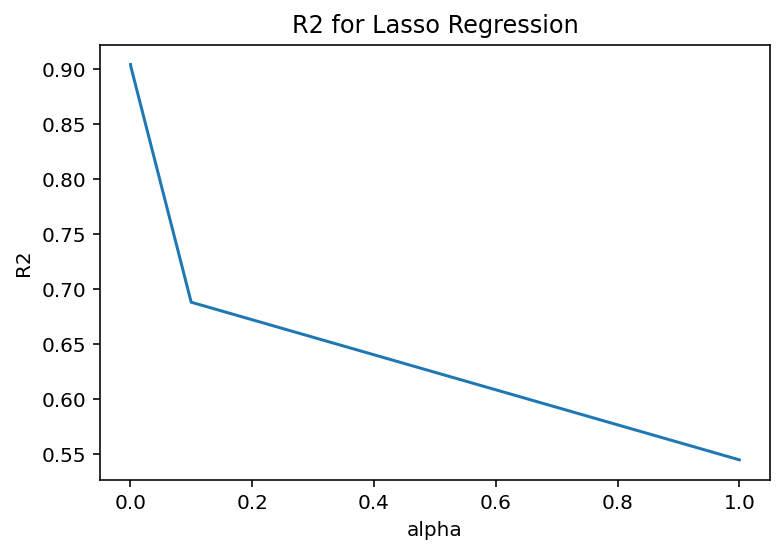

In [22]:

plt.figure(figsize=(6,4))
cv_r2_lasso.plot(title = "R2 for Lasso Regression")
plt.xlabel("alpha")
plt.ylabel("R2")
plt.show()

In [23]:
print("Best RMSE %.3f for alpha %.3f"%(cv_lasso.min(),cv_lasso.idxmin()))
print("Best R2 %.3f for alpha %.3f"%(cv_r2_lasso.max(),cv_r2_lasso.idxmax()))

Best RMSE 0.122 for alpha 0.001
Best R2 0.904 for alpha 0.001


## Lasso & Ridge with Built-in Crossvalidation
We performed the cross validation explicitly, but sklearn also provides two functions that include crossvalidation as part of the process, namely, LassoCV and RidgeCV. 

In [24]:
model_ridge = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv=KFold(10, shuffle=True, random_state=12345678)).fit(X_train, y)
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005],cv=KFold(10, shuffle=True, random_state=12345678)).fit(X_train, y)

We evaluate the resulting model using the same procedure we applied before.

In [25]:
rmse_lasso2 = rmse_cv(model_lasso, X_train, y)
rmse_ridge2 = rmse_cv(model_ridge, X_train, y)

r2_lasso2 = r2_cv(model_lasso, X_train, y)
r2_ridge2 = r2_cv(model_ridge, X_train, y)

Finally, we compare the results achieved with this procedure with the ones compared with the explicit cross validation. 

In [26]:
print("Ridge Regression (10-fold crossvalidation)")
print("\tRMSE=%.3f R2=%.3f for Alpha=%.3f"%(rmse_ridge2.mean(), r2_ridge2.mean(), model_ridge.alpha_))
print("\n")
print("Lasso Regression (10-fold crossvalidation)")
print("\tRMSE=%.3f R2=%.3f for Alpha=%.3f"%(rmse_lasso2.mean(), r2_lasso2.mean(), model_lasso.alpha_))

Ridge Regression (10-fold crossvalidation)
	RMSE=0.126 R2=0.896 for Alpha=15.000


Lasso Regression (10-fold crossvalidation)
	RMSE=0.122 R2=0.904 for Alpha=0.001


The results are similar to the ones we obtained with the explicit search for $\alpha$. 


## Feature Selection
One nice feature of Lasso regression is that by zeroing out the coefficients of variables that it deems unimportant, it actually performs feature selection. In practise, it simplifies the data while building the model.

In [27]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [28]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 105 variables and eliminated the other 195 variables


Note that, the process is stochastic and thus we cannot be sure that the selected variables are exactly the good ones so one approach is to run the procedure several times (using bootstrap which we will discuss later in the course) to check how robust the feature selection is. For instance, we check if there are variables whose weight is always zeroed out. As an example, let's plot the largest and the smallest coefficients.

In [29]:
imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

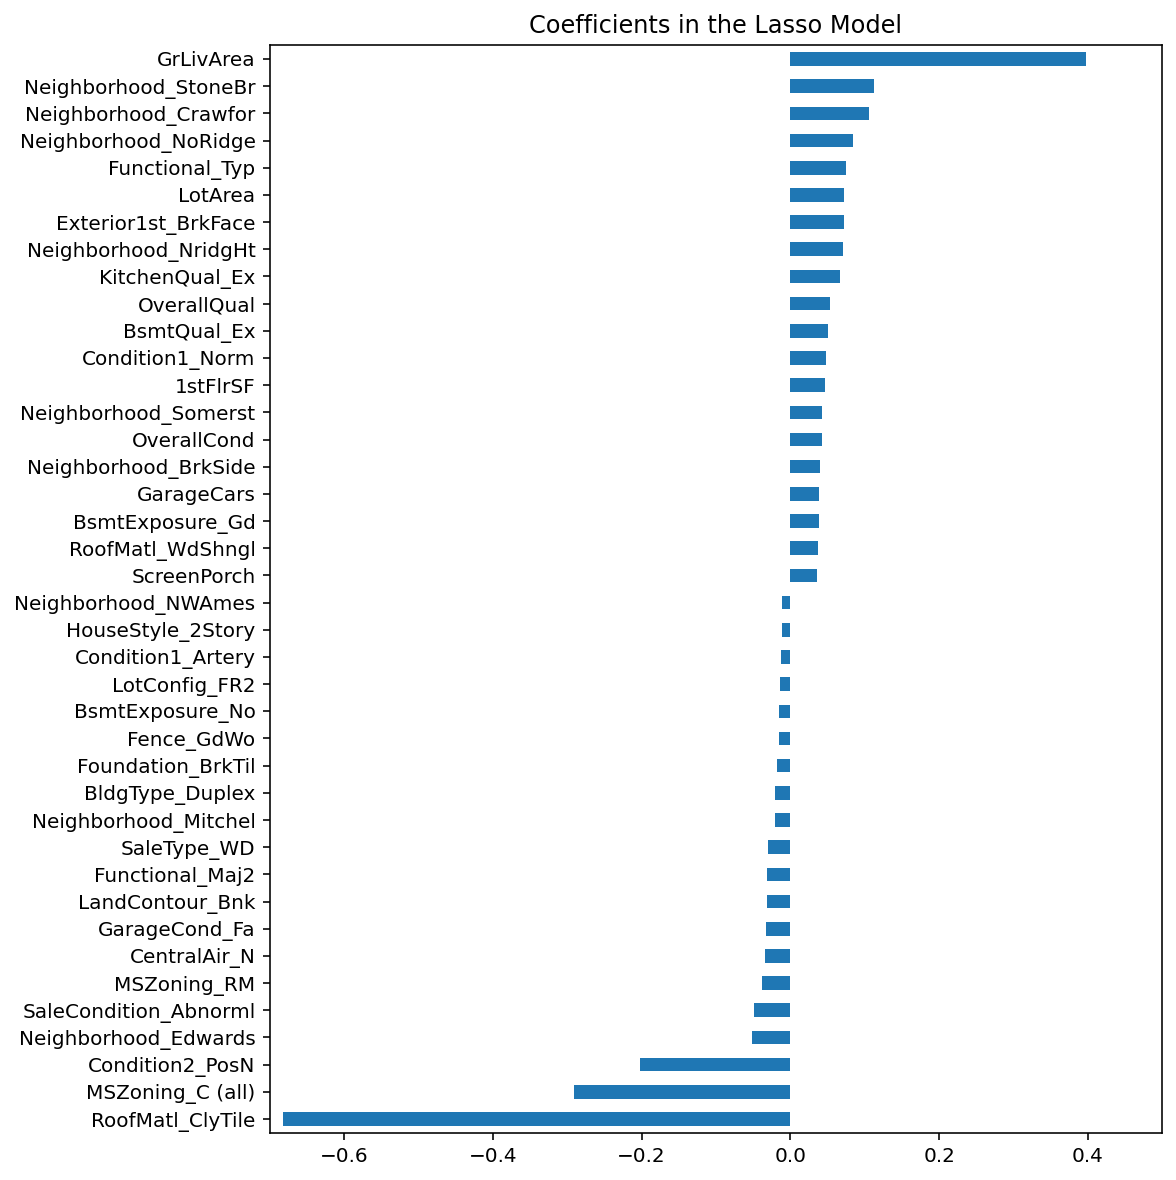

In [30]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.xlim(-0.7,0.5)
plt.show()

**GrLivArea** appears to be the most important positive feature (it identifies the above ground area by area square feet so it makes sense). Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more.

Let's also check the residuals, that is the difference between the predicted and the actual value plotted against the predicted value.

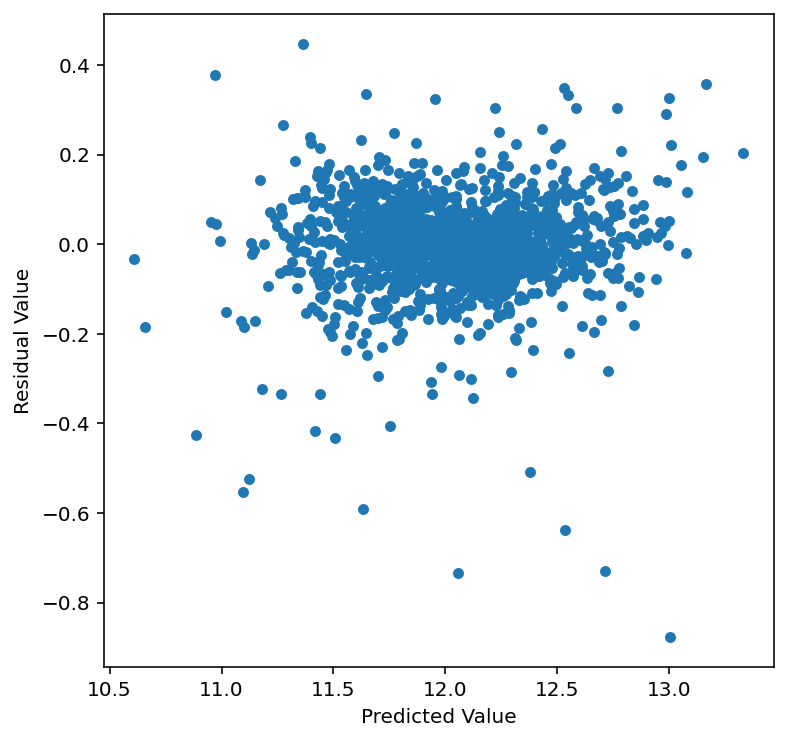

In [31]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.xlabel("Predicted Value")
plt.ylabel("Residual Value")
plt.show()

In [33]:
ridge_coef = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(ridge_coef != 0)) + " variables and eliminated the other " +  str(sum(ridge_coef == 0)) + " variables")

Ridge picked 300 variables and eliminated the other 0 variables


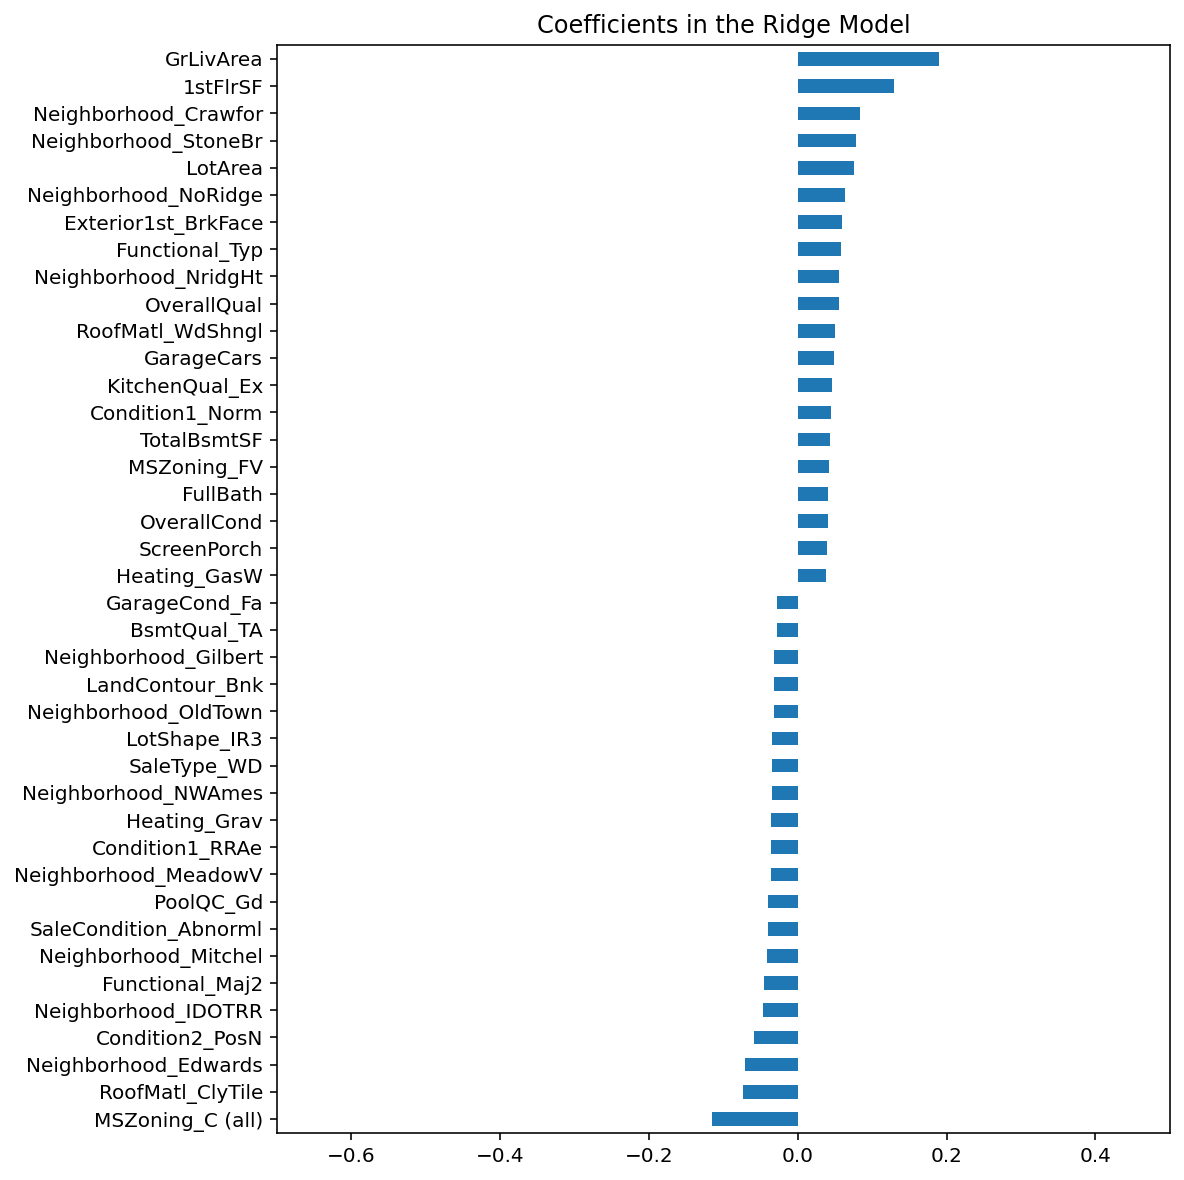

In [34]:
ridge_imp_coef = pd.concat([ridge_coef.sort_values().head(20),
                     ridge_coef.sort_values().tail(20)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
ridge_imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.xlim(-0.7,0.5)
plt.show()